# Anomaly Detection

In [1]:
import pandas as pd
import numpy as np
import sys
sys.path.append('/Users/josuealemansanchez/Desktop/eco-tools')
from ecotools.pi_client import pi_client
pc = pi_client(root = 'readonly')
from data_helper import *
import warnings
warnings.filterwarnings('ignore')

## Get Data

In [2]:
#search for point if needed
point = pc.search_by_point('*gbsf*elec*demand*kbtu*')
point

['GBSF_Electricity_Demand_kBtu']

### Set Data Parameters

In [3]:
start = '2016-01-01'
end = '*'
interval = '1h'
calculation = 'summary'

### Ensure only one point is passed

Grabbing WebIDs ...
WebID collection complete!
16:01:10: Sending API request... Chunk 1 of 1
16:01:12: Response recieved for 1 tags! (1.49)


Column                      |Percent NaN | Rows NaN/Total Rows
--------------------------------------------------------------
GBSF_Electricity_Demand_kBtu|  0.07 %    | 23/31524


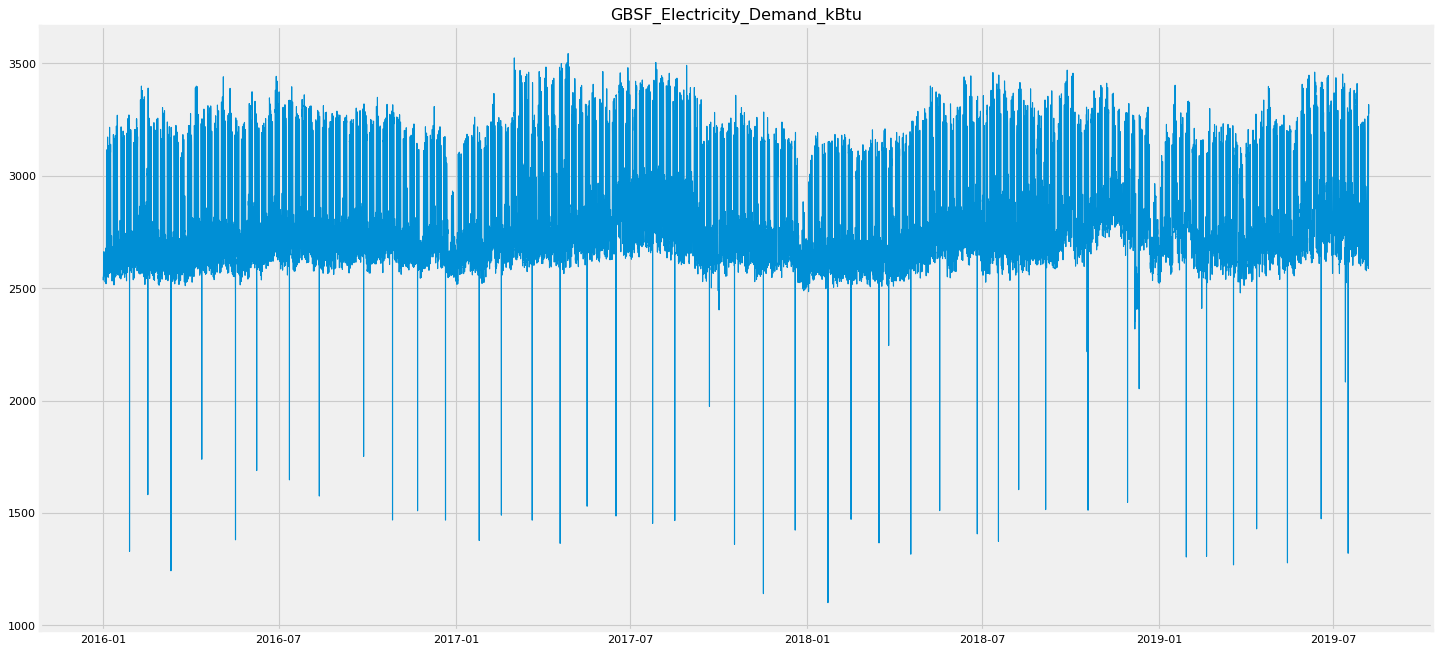

In [4]:
df = pc.get_stream_by_point(point, start = start, end = end, interval = interval, calculation = calculation)
print_report(df)

## Generate Model

In [5]:
kwargs = {
    #the point to be evaluated
    'point': point[0],
    
    #can be either 'LSTM' or 'Random Forest'
    'model_type': 'LSTM',
################################### Data Pre-processing ################################    
    #Determining the amount of data that will be used to train the model 0 < training_percent < 1.0
    'training_percent': 0.7,
    
    #determine if use wants the data to be cleaned 
    'clean_data': True,
    #clean_type can be either 'value' (any points below the value passed will be cut out) or 'iqr'
    'clean_type': 'iqr',

    #if clean is 'value' then pass the value you want the cut to be
    # if you want IQR then determine the IQR to cut at
    'threshold': 2.500,
    
    #Show plot with cutoff(s)
    'show_cutoff_plot': True,
    
    #show plot with training and testing data
    'show_cleaned_plot': True,
##############################################################    
    
    #determine if model should train on residuals or the normal data
    'train_on_residuals': True,
    
    #determine what method to use 'bfill' (back fill) or 'ffill' (foward fill) data 
    'method': 'bfill'
}

In [6]:
check_kwargs(kwargs)

'Good values!'

lower_bound: 1674.228911 and upper_bound: 4001.319524


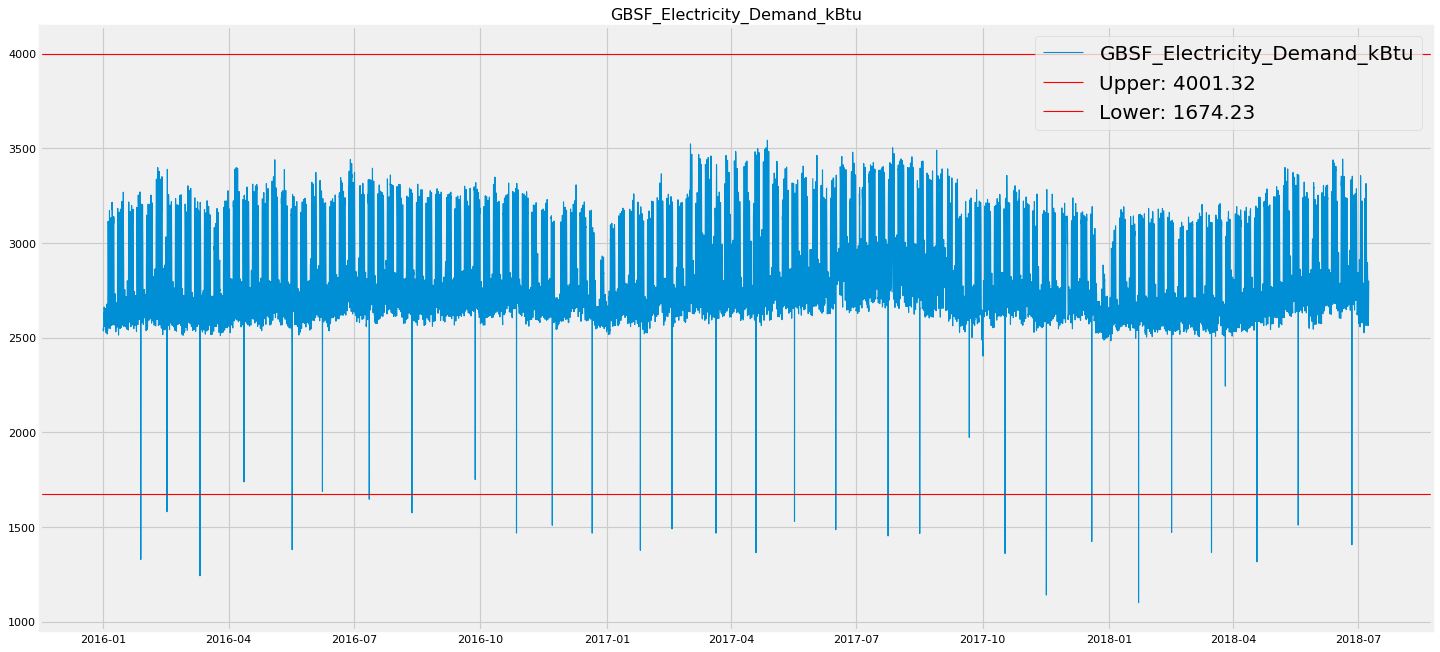

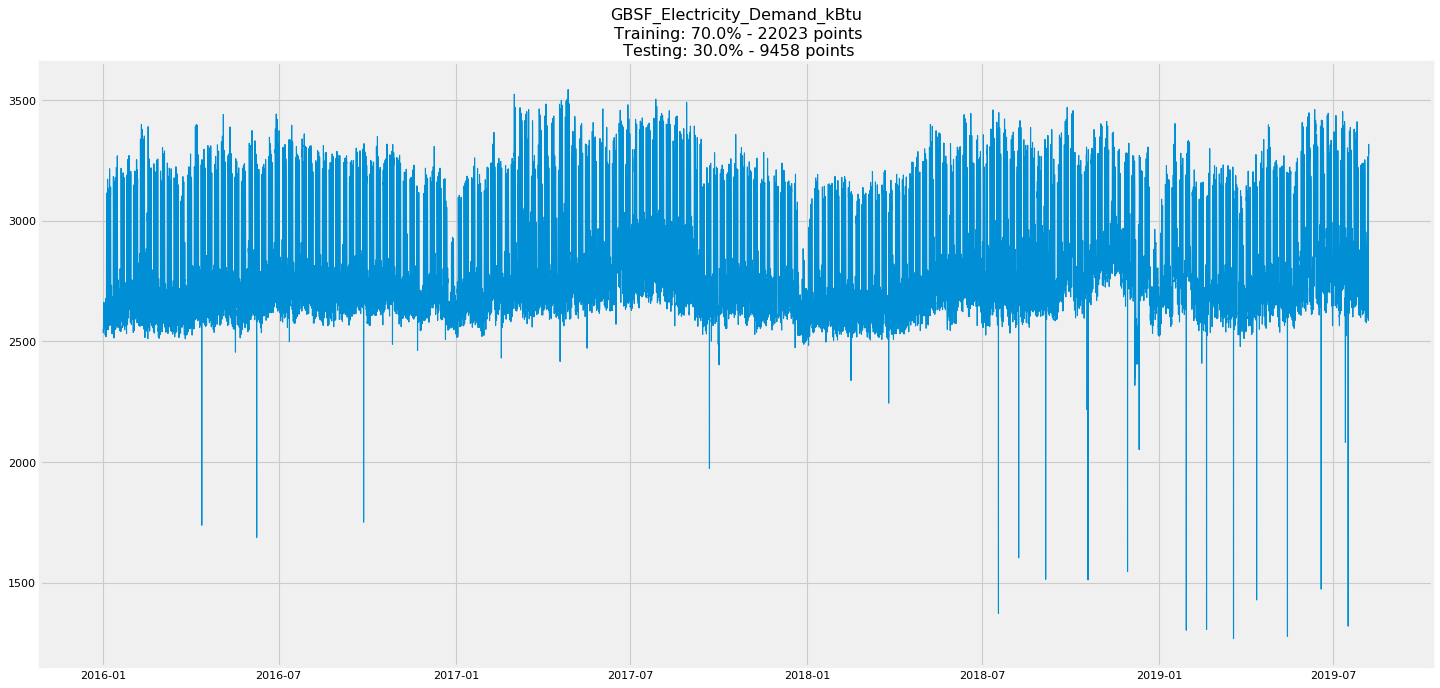

In [7]:
df1 = split_and_clean(df, kwargs)

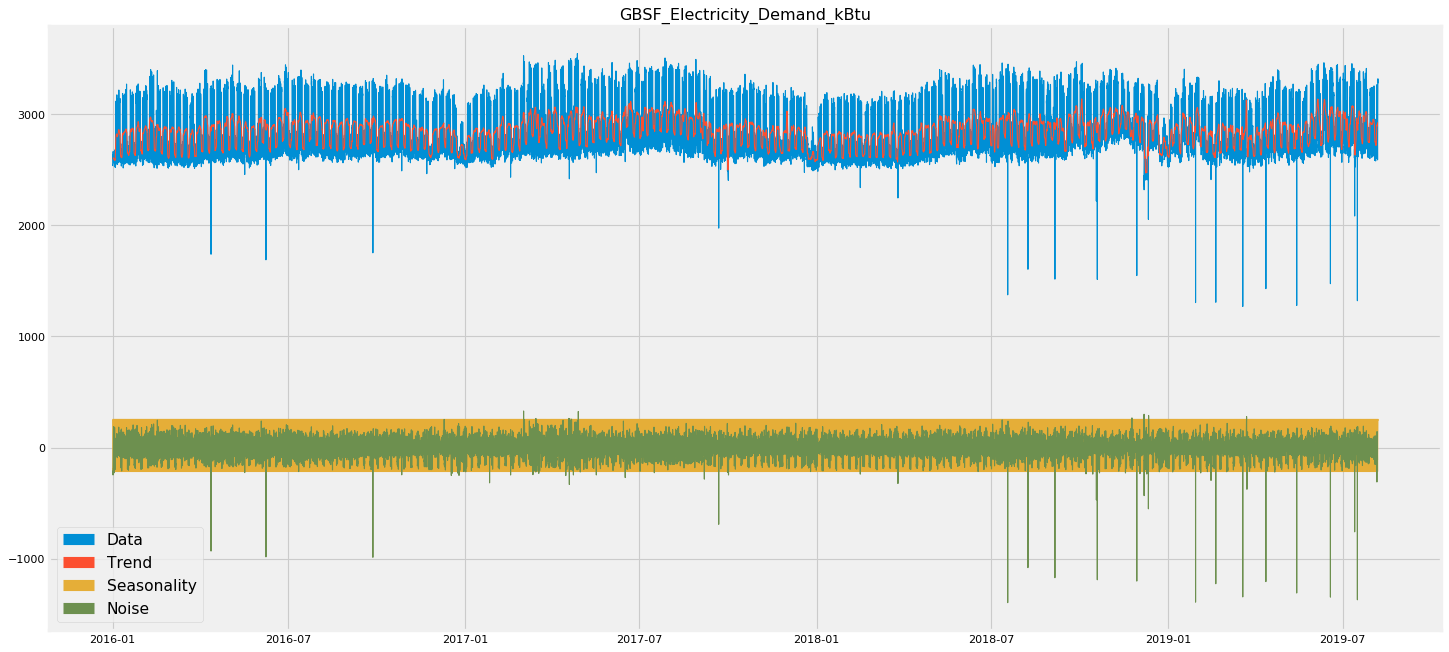

In [10]:
plot_decomposed_data(df1[point[0]], kwargs)